# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
from collections import deque
from importlib import reload
import matplotlib.pyplot as plt
%matplotlib inline

import ddpg_agent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='/home/mal/udacity_drl/deep-reinforcement-learning/p2_continuous-control/Reacher_Linux/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#     print(actions)
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.1099999975413084


### 4. Train the agents with DDPG

Run the code cell below to train the agent from scratch.  

Alternatively, you can skip to the next step below (**5. Watch a Smart Agent!**), to load the saved model weights from a pre-trained agent.

/home/mal/udacity_drl/deep-reinforcement-learning/p2_continuous-control/udacity-drl-p2-continuous-control/ddpg_agent.py:116: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)


Episode 100	Average Score: 7.85
Episode 200	Average Score: 16.83
Episode 300	Average Score: 24.38
Episode 351	Average Score: 30.02
Environment solved in 251 episodes!	Average Score: 30.02


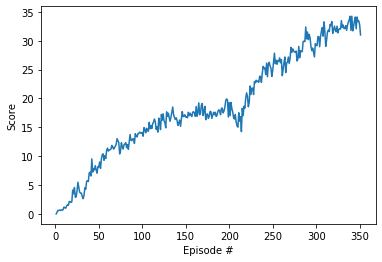

In [7]:
reload(ddpg_agent)
from ddpg_agent import Agent

agent = Agent(state_size=33, action_size=4, random_seed=2)

def multi_ddpg(n_episodes=2000, max_t=1000000, print_every=100, num_agents=1):
    scores_deque = deque(maxlen=print_every)
    scores = []                                 # list containing average agent scores from each episode
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
         
        agent.reset()
#       score = 0
        agents_scores = np.zeros(num_agents)                  # list containing the scores of each agent in the last episode
        for t in range(max_t):
            actions = np.zeros((num_agents,action_size))
            for i_agent in range(num_agents):
                action = agent.act(states[i_agent])
                actions[i_agent] = action
            #print("Action: \n")
            #print(actions)

            # next_state, reward, done, _ = env.step(action)
            actions = np.clip(actions, -1, 1)   # all actions between -1 and 1
            env_info = env.step(actions)[brain_name] 
            
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            
            for i_agent in range(num_agents):
                 agent.add_to_memory(states[i_agent], actions[i_agent], rewards[i_agent], next_states[i_agent], dones[i_agent])
            # agent.step(state, action, reward, next_state, done)
            
            if t % 20 == 0:
                for i in range(10):
                    agent.learn_from_replay()
            
            agents_scores += rewards                        # update the score (for each agent)
            states = next_states
            #state = next_state
            #score += reward
            if np.any(dones):
                break
        score = np.mean(agents_scores)
        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
    return scores

scores = multi_ddpg(n_episodes= 2000, num_agents= num_agents)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent trained by me!

In [ ]:
from ddpg_agent import Agent
agent = Agent(state_size=33, action_size=4, random_seed=2)


# load the weights from file
agent.actor_local.load_state_dict(torch.load('trained_model_actor.pth'))
agent.critic_local.load_state_dict(torch.load('trained_model_critic.pth'))


for i in range(3):
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0] 
    for j in range(300):
        
        actions = np.zeros((num_agents,action_size))
        for i_agent in range(num_agents):
            action = agent.act(states[i_agent])
            actions[i_agent] = action
        actions = np.clip(actions, -1, 1)   # all actions between -1 and 1
        env_info = env.step(actions)[brain_name] 
                
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        states = next_states
        if np.any(dones):
                break 

### 6. Watch Your Agent!

In the next code cell, you will load the trained weights from the training performed by you to watch the agent trained by you!

In [ ]:
from ddpg_agent import Agent
agent = Agent(state_size=33, action_size=4, random_seed=2)


# load the weights from file
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))


for i in range(3):
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0] 
    for j in range(300):
        
        actions = np.zeros((num_agents,action_size))
        for i_agent in range(num_agents):
            action = agent.act(states[i_agent])
            actions[i_agent] = action
        actions = np.clip(actions, -1, 1)   # all actions between -1 and 1
        env_info = env.step(actions)[brain_name] 
                
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        states = next_states
        if np.any(dones):
                break 

### 7. Close the environment
When finished, you can close the environment.

In [ ]:
env.close()